In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0



In [3]:
from cohlib.utils import pickle_save, gamma_root, pickle_open
# from cohlib.jax.gamma_create import k2_full
from cohlib.jax.dists import cif_alpha_relu, sample_spikes_from_lams

In [4]:
def plot_data(gamma_true_full, lseed, oseed, alpha, L, k=0):

    lrk = jr.key(lseed)
    zs = sample_from_gamma(lrk, gamma_true_full, L)

    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    ork = jr.key(oseed)

    obs = sample_spikes(ork, xs, alpha)

    fig, ax = plt.subplots(2,1,figsize=(5,3))
    for l in range(3):
        ax[0].plot(xs[:,k,l])
        ax[1].plot(obs[:,k,l])
    plt.tight_layout()


In [5]:
def pow(gamma, k, db=False, freq_inds=None):
    if freq_inds is None:
        freq_inds = jnp.arange(gamma.shape[0])
    S = gamma[freq_inds,k,k].real
    if db is True:
        S = 10*jnp.log10(S+1e-15)
    return S

def cif_alpha_log(alphas, xs):
    return jnp.exp(alphas[None,:,None] + xs)


### Load Gamma and Jax Results

In [6]:
from cohlib.utils import gamma_root
# gamma_name = 'k2-single-10'
flow=1
fhigh=50
spt=5
spot=1
gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{spt}-{spot}.pickle")
gamma_load = pickle_open(gamma_path)
gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']

scale = 1

gamma_full = gamma_full*scale

nz_target = jnp.array([9])
K = gamma_full.shape[-1]

L = 50
lseed = 7
lrk = jr.key(lseed)

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)


In [14]:
def sample_spikes(rk, xs, alpha, C=1, delta=1e-3):
    K = xs.shape[1]
    alphas = jnp.ones(K)*alpha
    lams_single = cif_alpha_log(alphas, xs)
    lams = jnp.stack([lams_single for _ in range(C)], axis=1)
    samples = jr.poisson(rk, lams*delta)
    return lams.squeeze(), samples.squeeze()

alpha = 3.5
oseed = 7
ork = jr.key(oseed) 
lams, samples_pre = sample_spikes(ork, xs, alpha)
samples = samples_pre

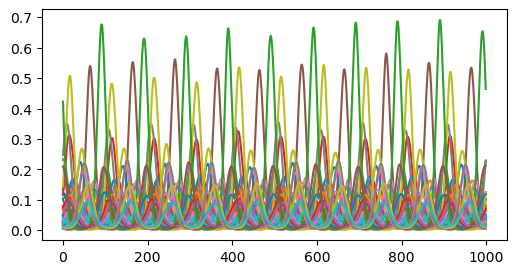

In [15]:
delta = 1e-3
k = 0
l = 0
fig, ax = plt.subplots(figsize=(6,3))

for l in range(L):
    ax.plot(lams[:,k,l]*delta)

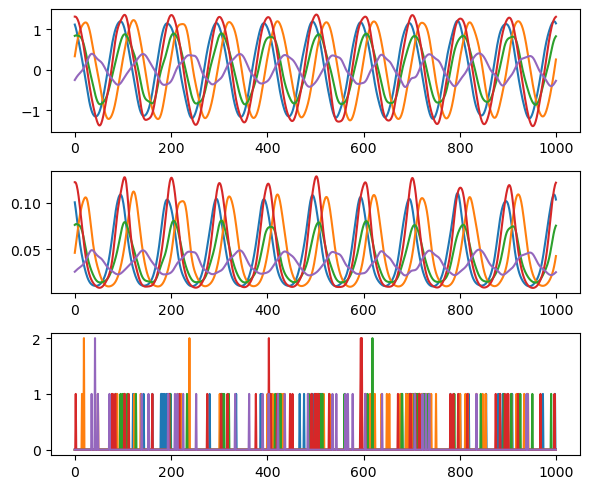

In [16]:
delta = 1e-3
k = 0
l = 0
fig, ax = plt.subplots(3,1, figsize=(6,5))

for l in range(5):
    ax[0].plot(xs[:,k,l])
    ax[1].plot(lams[:,k,l]*delta)
    ax[2].plot(samples[:,k,l])

plt.tight_layout()

In [17]:
samples.shape

(1000, 2, 50)

In [18]:
def naive_estimator(spikes, nonzero_inds=None):
    "spikes has shape (time, unit, trial)"
    n_f0 = jnp.fft.rfft(spikes, axis=0)
    n_f = n_f0[1:,:,:]
    naive_est = jnp.einsum('jkl,jil->jkil', n_f, n_f.conj()).mean(-1)

    if nonzero_inds is None:
        return naive_est
    else:
        return naive_est[nonzero_inds, :, :]


In [19]:
naive_est = naive_estimator(samples, nz)

In [20]:
gamma_full[9]*1e-3

Array([[500.00003  +0.j     , 100.00001-100.00001j],
       [100.00001+100.00001j, 500.00003  +0.j     ]], dtype=complex64)

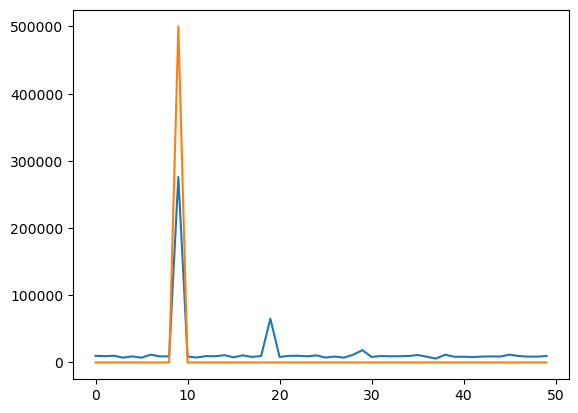

In [39]:
k = 0
plt.plot(naive_est[:,k,k].real * 1e3 / (2*jnp.pi))
plt.plot(gamma_full[nz,k,k].real)

#### Perfect
Next.. 
- copy workflow from previously for Gaussian obs
- implement jax pp with relu
- compare behavior to naive / old
- see if we can replicate jax behavior by modifying old like w/ gaussian obs

### Let's work out cost function here

In [18]:
def _obs_cost_gaussian(z, data, K, N, nonzero_inds, params, zs_flattened):
    obs_var = params['obs_var']
    if zs_flattened:
        z = z.reshape(-1,K)
    zs = jnp.zeros((N,K), dtype=complex)
    zs = zs.at[nonzero_inds,:].set(z)

    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)
    err = (data - xs)

    # partial_ll = -0.5 * (err**2 * 1/obs_var).sum()
    a = -0.5 * (err**2 * 1/obs_var)
    b = a.sum(0)
    partial_ll = b.sum()
    
    obs_cost = -partial_ll

    return obs_cost

def _obs_cost_pp_relu(z, data, K, N, nonzero_inds, params, zs_flattened):
    alpha = params['alpha']
    delta = params['delta']
    if zs_flattened:
        z = z.reshape(-1,K)
    zs = jnp.zeros((N,K), dtype=complex)
    zs = zs.at[nonzero_inds,:].set(z)

    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    if jnp.ndim(alpha) == 0:
        lams = xs + alpha
    else:
        xs + alphas[None,:,None]

    lams = lams.at[lams < 0].set(jnp.nan)
    log_lams = jnp.nan_to_num(jnp.log(lams), nan=0, neginf=0, posinf=0)
    partial_ll_calc = obs*(jnp.log(delta) + log_lams) - jnp.nan_to_num(lams)*delta
    partial_ll = partial_ll_calc.sum()
    obs_cost = -partial_ll

    return obs_cost
     


In [19]:
alphas = jnp.array([alpha, alpha])
xs + alphas[None,:,None]

Array([[[ 98.304436, 135.12181 ,  91.28735 , ...,  85.023636,
          88.58696 , 105.30442 ],
        [ 51.298714,  84.864586,  62.66922 , ...,  77.75635 ,
          58.04809 , 121.94153 ]],

       [[ 97.06844 , 136.72223 ,  91.03629 , ...,  85.717415,
          88.11182 , 108.377594],
        [ 53.32878 ,  83.459694,  61.895027, ...,  79.34633 ,
          59.387085, 122.94228 ]],

       [[ 95.91242 , 138.18211 ,  90.85875 , ...,  86.39891 ,
          87.63446 , 111.403175],
        [ 55.498066,  82.0044  ,  61.264   , ...,  80.97072 ,
          60.89205 , 123.88448 ]],

       ...,

       [[102.31854 , 129.5189  ,  92.61226 , ...,  82.9096  ,
          90.04618 ,  95.95894 ],
        [ 46.109905,  88.64147 ,  65.69317 , ...,  73.355446,
          55.109276, 118.60285 ]],

       [[100.95042 , 131.51593 ,  92.067474, ...,  83.61057 ,
          89.54537 ,  99.07903 ],
        [ 47.67945 ,  87.4597  ,  64.58417 , ...,  74.741806,
          55.902153, 119.77194 ]],

       [[ 99.6049

In [20]:
obs = samples.copy()
delta = 1e-3
alpha = 5


lams = xs + alpha
lams = lams.at[lams < 0].set(jnp.nan)
log_lams = jnp.nan_to_num(jnp.log(lams), nan=0, neginf=0, posinf=0)
cost_calc = obs*(jnp.log(delta) + log_lams) - jnp.nan_to_num(lams)*delta
cost = cost_calc.sum()

In [21]:
len(jnp.shape(alpha))

0

In [25]:
lams = xs + alpha
lams = lams.at[lams < 0].set(jnp.nan)
lams

Array([[[ 3.3044324 , 40.121815  ,         nan, ...,         nan,
                 nan, 10.304419  ],
        [        nan,         nan,         nan, ...,         nan,
                 nan, 26.941528  ]],

       [[ 2.0684435 , 41.72222   ,         nan, ...,         nan,
                 nan, 13.377596  ],
        [        nan,         nan,         nan, ...,         nan,
                 nan, 27.942282  ]],

       [[ 0.91242266, 43.182117  ,         nan, ...,         nan,
                 nan, 16.40318   ],
        [        nan,         nan,         nan, ...,         nan,
                 nan, 28.884481  ]],

       ...,

       [[ 7.3185406 , 34.518898  ,         nan, ...,         nan,
                 nan,  0.958941  ],
        [        nan,         nan,         nan, ...,         nan,
                 nan, 23.602852  ]],

       [[ 5.9504175 , 36.51593   ,         nan, ...,         nan,
                 nan,  4.0790324 ],
        [        nan,         nan,         nan, ...,         

In [26]:
lams = xs + alpha
lams = jnp.where(lams < 0, jnp.nan, lams)
lams

Array([[[ 3.3044324 , 40.121815  ,         nan, ...,         nan,
                 nan, 10.304419  ],
        [        nan,         nan,         nan, ...,         nan,
                 nan, 26.941528  ]],

       [[ 2.0684435 , 41.72222   ,         nan, ...,         nan,
                 nan, 13.377596  ],
        [        nan,         nan,         nan, ...,         nan,
                 nan, 27.942282  ]],

       [[ 0.91242266, 43.182117  ,         nan, ...,         nan,
                 nan, 16.40318   ],
        [        nan,         nan,         nan, ...,         nan,
                 nan, 28.884481  ]],

       ...,

       [[ 7.3185406 , 34.518898  ,         nan, ...,         nan,
                 nan,  0.958941  ],
        [        nan,         nan,         nan, ...,         nan,
                 nan, 23.602852  ]],

       [[ 5.9504175 , 36.51593   ,         nan, ...,         nan,
                 nan,  4.0790324 ],
        [        nan,         nan,         nan, ...,         

In [23]:
jnp.ndim(alpha)

0